In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, skew
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

In [2]:
inverter1 = pd.read_excel(r'C:/Users/Lenovo/Downloads/Anomaly detection in solar power generation/Data Set/Project-DataSet-15-10-2024.xlsx', sheet_name=1, skiprows=lambda x: x == 1)
inverter2 = pd.read_excel(r'C:/Users/Lenovo/Downloads/Anomaly detection in solar power generation/Data Set/Project-DataSet-15-10-2024.xlsx', sheet_name=2, skiprows=lambda x: x == 1)
inverter3 = pd.read_excel(r'C:/Users/Lenovo/Downloads/Anomaly detection in solar power generation/Data Set/Project-DataSet-15-10-2024.xlsx', sheet_name=3, skiprows=lambda x: x == 1, parse_dates=['DATE & TIME'])
weather = pd.read_excel(r'C:/Users/Lenovo/Downloads/Anomaly detection in solar power generation/Data Set/Project-DataSet-15-10-2024.xlsx', sheet_name=5, parse_dates=['DATE & TIME'])

In [3]:
# Add inverter identifier
inverter1['Inverter'] = 'INVERTER1'
inverter2['Inverter'] = 'INVERTER2'
inverter3['Inverter'] = 'INVERTER3'

In [4]:
# Combine inverter data
inverters = pd.concat([inverter1, inverter2, inverter3], ignore_index=True)

inverters['DATE & TIME'] = pd.to_datetime(inverters['DATE & TIME'], format='mixed').dt.floor('s')

# inverters['DATE & TIME'] = pd.to_datetime(inverters['DATE & TIME']).dt.strftime('%Y-%m-%d %H:%M')

weather['DATE & TIME'] = pd.to_datetime(weather['DATE & TIME'], format='mixed').dt.floor('s')

# weather['DATE & TIME'] = pd.to_datetime(weather['DATE & TIME']).dt.strftime('%Y-%m-%d %H:%M')

print(inverters.dtypes)

# Merge with weather data
data = pd.merge(inverters, weather, on='DATE & TIME', how='outer')

DATE & TIME    datetime64[ns]
DC CURRENT            float64
DC VOLTAGE            float64
DC POWER              float64
TEMPERATURE           float64
Inverter               object
dtype: object


In [5]:
data.describe()

,DATE & TIME,DC CURRENT,DC VOLTAGE,DC POWER,TEMPERATURE,GHI,GII,MODULE TEMP.1,MODULE TEMP.2,RAIN,WIND DIRECTION,WIND SPEED,HUMIDITY,AMBIENT TEMPERATURE
count,526920,526920.000000,526920.000000,526920.000000,526920.000000,269343.000000,269343.000000,269343.000000,269343.000000,269343.000000,269343.0,269343.0,269343.000000,269343.000000
mean,2024-05-01 00:12:59.424003584,652.829043,846.066118,714.936422,34.879923,462.494982,456.949388,41.696916,43.890500,0.000323,0.0,0.0,51.642560,33.292611
min,2024-03-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
25%,2024-03-31 12:28:45,0.000000,904.799988,0.000000,31.000000,164.000000,157.000000,32.200001,33.799999,0.000000,0.0,0.0,35.900002,29.100000
50%,2024-05-01 00:19:30,31.100000,1094.199951,32.400002,34.500000,441.000000,432.000000,42.500000,44.700001,0.000000,0.0,0.0,48.000000,33.400002
75%,2024-05-31 12:09:15,1258.599976,1113.800049,1399.900024,38.500000,764.000000,768.000000,52.200001,55.000000,0.000000,0.0,0.0,66.400002,38.099998
max,2024-06-30 23:59:00,2698.100098,1406.099976,2875.500000,51.400002,1279.000000,1234.000000,65.400002,70.400002,0.600000,0.0,0.0,99.900002,47.599998
std,NaN,891.467440,458.476980,970.770440,5.445304,313.112484,313.748210,12.209562,12.986151,0.008773,0.0,0.0,20.734192,5.844004


In [7]:
# Drop Near-Zero Variance and Zero-Variance Columns
data = data.drop(columns= [ "RAIN", "WIND DIRECTION", "WIND SPEED"])

# Set datetime as index
data.set_index('DATE & TIME', inplace=True)

# Fill NaN values with 0 for all columns except 'Inverter'
numerical_columns = data.columns.difference(['Inverter'])  # Exclude 'Inverter'
data[numerical_columns] = data[numerical_columns].fillna(0)

# data.info()

#Using the category data type for categorical variable like Inverter (if treated categorically) can save memory.
data['Inverter'] = data['Inverter'].astype('category')

# data.info()

# Optimizing the datatypes
data['DC CURRENT'] = data['DC CURRENT'].astype('float32')
data['DC VOLTAGE'] = data['DC VOLTAGE'].astype('float32')
data['DC POWER'] = data['DC POWER'].astype('float32')
data['TEMPERATURE'] = data['TEMPERATURE'].astype('float32')
data['MODULE TEMP.1'] = data['MODULE TEMP.1'].astype('float32')
data['MODULE TEMP.2'] = data['MODULE TEMP.2'].astype('float32')
data['HUMIDITY'] = data['HUMIDITY'].astype('float32')
data['AMBIENT TEMPERATURE'] = data['AMBIENT TEMPERATURE'].astype('float32')

# Converting 'Inverter' to category
data['Inverter'] = data['Inverter'].astype('category')

# Converting GHI and GII to integers, using int8 or int16 based on the range
data['GHI'] = data['GHI'].astype('int32')
data['GII '] = data['GII '].astype('int32')

# Verify the memory usage after optimization
# print(data.info())

# Remove extra spaces from all column names
data.columns = data.columns.str.strip()

# Extract temporal features
data['Hour'] = data.index.hour.astype('int8')
data['Day'] = data.index.day.astype('int8')
data['Month'] = data.index.month.astype('int8')

# Calculate Power_per_GHI, handling division by zero
data['Power_per_GHI'] = (data['DC POWER'] / data['GHI'].replace(0, np.nan)).astype('float32')
data['Power_per_GHI'].fillna(0, inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20820\3418092625.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Power_per_GHI'].fillna(0, inplace=True)


In [8]:
data

,DC CURRENT,DC VOLTAGE,DC POWER,TEMPERATURE,Inverter,GHI,GII,MODULE TEMP.1,MODULE TEMP.2,HUMIDITY,AMBIENT TEMPERATURE,Hour,Day,Month,Power_per_GHI
DATE & TIME,,,,,,,,,,,,,,,
2024-03-01 00:00:00,0.0,0.000000,0.0,29.799999,INVERTER1,0,0,0.0,0.0,0.0,0.0,0,1,3,0.0
2024-03-01 00:00:00,0.0,0.000000,0.0,30.600000,INVERTER2,0,0,0.0,0.0,0.0,0.0,0,1,3,0.0
2024-03-01 00:00:00,12.7,0.000000,0.0,27.500000,INVERTER3,0,0,0.0,0.0,0.0,0.0,0,1,3,0.0
2024-03-01 00:01:00,0.0,0.000000,0.0,29.799999,INVERTER1,0,0,0.0,0.0,0.0,0.0,0,1,3,0.0
2024-03-01 00:01:00,0.0,0.000000,0.0,30.600000,INVERTER2,0,0,0.0,0.0,0.0,0.0,0,1,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 23:58:00,0.0,0.000000,0.0,31.900000,INVERTER2,0,0,0.0,0.0,0.0,0.0,23,30,6,0.0
2024-06-30 23:58:00,0.0,1099.900024,0.0,27.200001,INVERTER3,0,0,0.0,0.0,0.0,0.0,23,30,6,0.0
2024-06-30 23:59:00,0.0,0.000000,0.0,31.200001,INVERTER1,0,0,0.0,0.0,0.0,0.0,23,30,6,0.0


In [9]:
# Calculate DC POWER from DC CURRENT and DC VOLTAGE
data['Calculated_DC_POWER'] = (data['DC CURRENT'] * data['DC VOLTAGE'])/1000

# Analyze the differences
data['Power_Match'] = np.isclose(data['Calculated_DC_POWER'], data['DC POWER'], rtol=1e-1)

# Count how many match and how many don't
power_matches = data['Power_Match'].value_counts()

# Print the counts of matches and mismatches
print("Power Matches:\n", power_matches)

# Optionally, if you want to see the mismatches:
mismatched_data = data[~data['Power_Match']]
print("\nMismatched Data:\n", mismatched_data[['DC CURRENT', 'DC VOLTAGE', 'DC POWER', 'Calculated_DC_POWER']])


Power Matches:
 Power_Match
True     526890
False        30
Name: count, dtype: int64

Mismatched Data:
                       DC CURRENT   DC VOLTAGE     DC POWER  \
DATE & TIME                                                  
2024-03-05 18:16:00    12.200000  1073.599976     0.000000   
2024-03-06 10:26:00  2224.899902  1114.400024  2226.100098   
2024-03-13 15:44:00   780.700012  1095.400024   752.700012   
2024-03-16 14:22:00  1594.599976  1086.699951  1552.099976   
2024-03-18 09:21:00   807.599976  1154.699951  1038.699951   
2024-05-19 05:36:00    39.000000  1003.000000     0.000000   
2024-05-20 05:44:00    32.299999  1087.099976    29.000000   
2024-05-21 18:14:00    20.900000  1101.000000    15.900000   
2024-05-22 05:35:00     0.000000  1196.699951    23.700001   
2024-05-22 12:32:00  2338.000000  1071.099976  2271.500000   
2024-05-22 15:44:00  1037.000000  1044.000000   983.900024   
2024-05-22 17:14:00     0.000000  1163.500000    20.799999   
2024-05-23 12:36:00  1755.0

In [11]:
data

,DC CURRENT,DC VOLTAGE,DC POWER,TEMPERATURE,Inverter,GHI,GII,MODULE TEMP.1,MODULE TEMP.2,HUMIDITY,AMBIENT TEMPERATURE,Hour,Day,Month,Power_per_GHI,Calculated_DC_POWER,Power_Match
DATE & TIME,,,,,,,,,,,,,,,,,
2024-03-01 00:00:00,0.0,0.000000,0.0,29.799999,INVERTER1,0,0,0.0,0.0,0.0,0.0,0,1,3,0.0,0.0,True
2024-03-01 00:00:00,0.0,0.000000,0.0,30.600000,INVERTER2,0,0,0.0,0.0,0.0,0.0,0,1,3,0.0,0.0,True
2024-03-01 00:00:00,12.7,0.000000,0.0,27.500000,INVERTER3,0,0,0.0,0.0,0.0,0.0,0,1,3,0.0,0.0,True
2024-03-01 00:01:00,0.0,0.000000,0.0,29.799999,INVERTER1,0,0,0.0,0.0,0.0,0.0,0,1,3,0.0,0.0,True
2024-03-01 00:01:00,0.0,0.000000,0.0,30.600000,INVERTER2,0,0,0.0,0.0,0.0,0.0,0,1,3,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 23:58:00,0.0,0.000000,0.0,31.900000,INVERTER2,0,0,0.0,0.0,0.0,0.0,23,30,6,0.0,0.0,True
2024-06-30 23:58:00,0.0,1099.900024,0.0,27.200001,INVERTER3,0,0,0.0,0.0,0.0,0.0,23,30,6,0.0,0.0,True
2024-06-30 23:59:00,0.0,0.000000,0.0,31.200001,INVERTER1,0,0,0.0,0.0,0.0,0.0,23,30,6,0.0,0.0,True


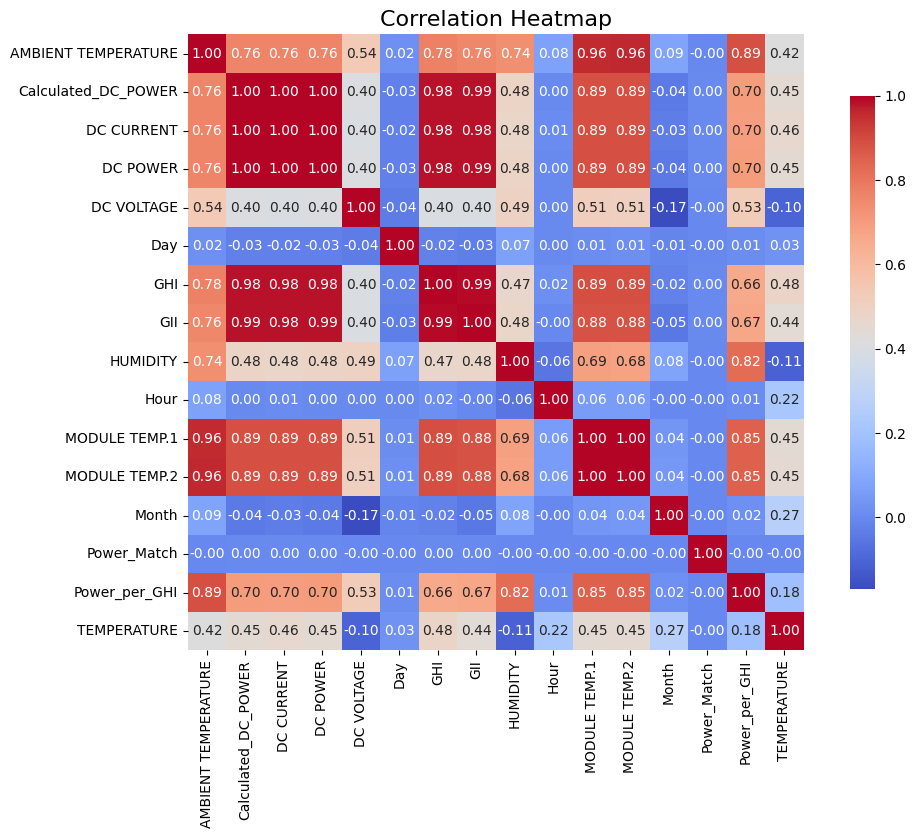

In [13]:
# Calculate the correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Heatmap', fontsize=16)

# Show the plot
plt.show()


In [14]:
# Remove columns with high correlation
columns_to_remove = ['GHI', 'GII', 'Calculated_DC_POWER', 'DC CURRENT', 'MODULE TEMP.1', 'MODULE TEMP.2', 'Power_per_GHI']
data = data.drop(columns=columns_to_remove)

# Verify the removal
print(data.columns)

Index(['DC VOLTAGE', 'DC POWER', 'TEMPERATURE', 'Inverter', 'HUMIDITY',
       'AMBIENT TEMPERATURE', 'Hour', 'Day', 'Month', 'Power_Match'],
      dtype='object')


In [15]:
data

,DC VOLTAGE,DC POWER,TEMPERATURE,Inverter,HUMIDITY,AMBIENT TEMPERATURE,Hour,Day,Month,Power_Match
DATE & TIME,,,,,,,,,,
2024-03-01 00:00:00,0.000000,0.0,29.799999,INVERTER1,0.0,0.0,0,1,3,True
2024-03-01 00:00:00,0.000000,0.0,30.600000,INVERTER2,0.0,0.0,0,1,3,True
2024-03-01 00:00:00,0.000000,0.0,27.500000,INVERTER3,0.0,0.0,0,1,3,True
2024-03-01 00:01:00,0.000000,0.0,29.799999,INVERTER1,0.0,0.0,0,1,3,True
2024-03-01 00:01:00,0.000000,0.0,30.600000,INVERTER2,0.0,0.0,0,1,3,True
...,...,...,...,...,...,...,...,...,...,...
2024-06-30 23:58:00,0.000000,0.0,31.900000,INVERTER2,0.0,0.0,23,30,6,True
2024-06-30 23:58:00,1099.900024,0.0,27.200001,INVERTER3,0.0,0.0,23,30,6,True
2024-06-30 23:59:00,0.000000,0.0,31.200001,INVERTER1,0.0,0.0,23,30,6,True


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20820\1706597274.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hourly_avg_power = data.groupby(['Hour', 'Inverter'])['DC POWER'].mean().reset_index()


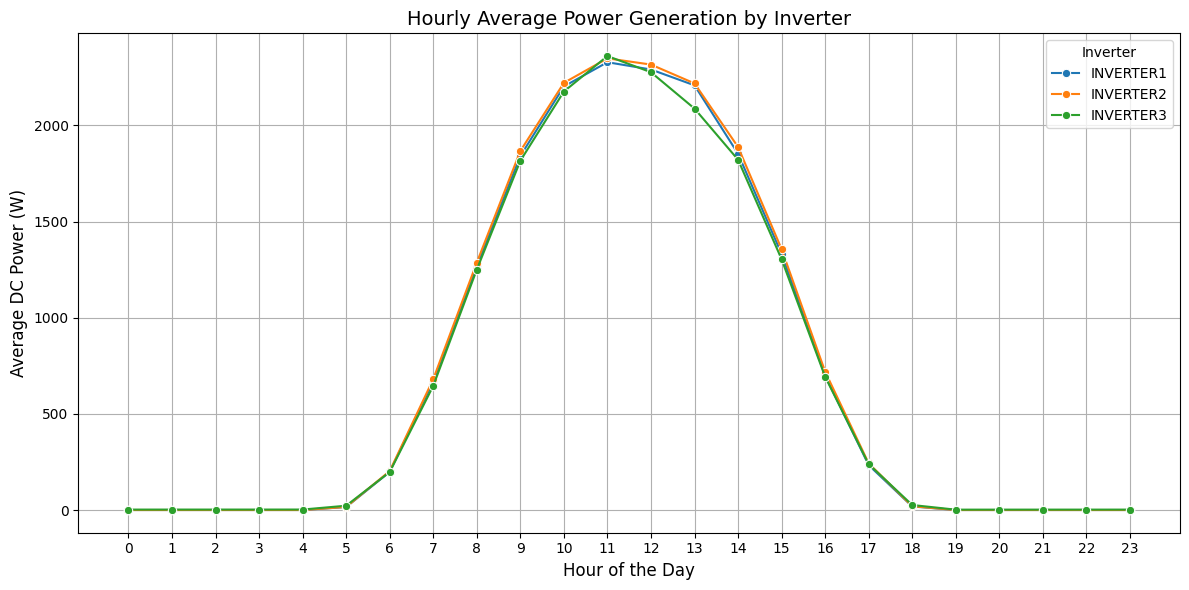

In [16]:
# Group by 'Hour' and 'Inverter', then calculate the mean of 'DC POWER' for each group
hourly_avg_power = data.groupby(['Hour', 'Inverter'])['DC POWER'].mean().reset_index()

# Plot the hourly average power for each inverter
plt.figure(figsize=(12, 6))
sns.lineplot(x='Hour', y='DC POWER', hue='Inverter', data=hourly_avg_power, marker='o')

# Adding labels and title
plt.title('Hourly Average Power Generation by Inverter', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average DC Power (W)', fontsize=12)
plt.xticks(ticks=range(0, 24), labels=range(0, 24))  # Ensure the x-axis has 24 hours
plt.grid(True)
plt.legend(title='Inverter', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20820\4232492717.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Day_avg_power = data.groupby(['Day', 'Inverter'])['DC POWER'].mean().reset_index()


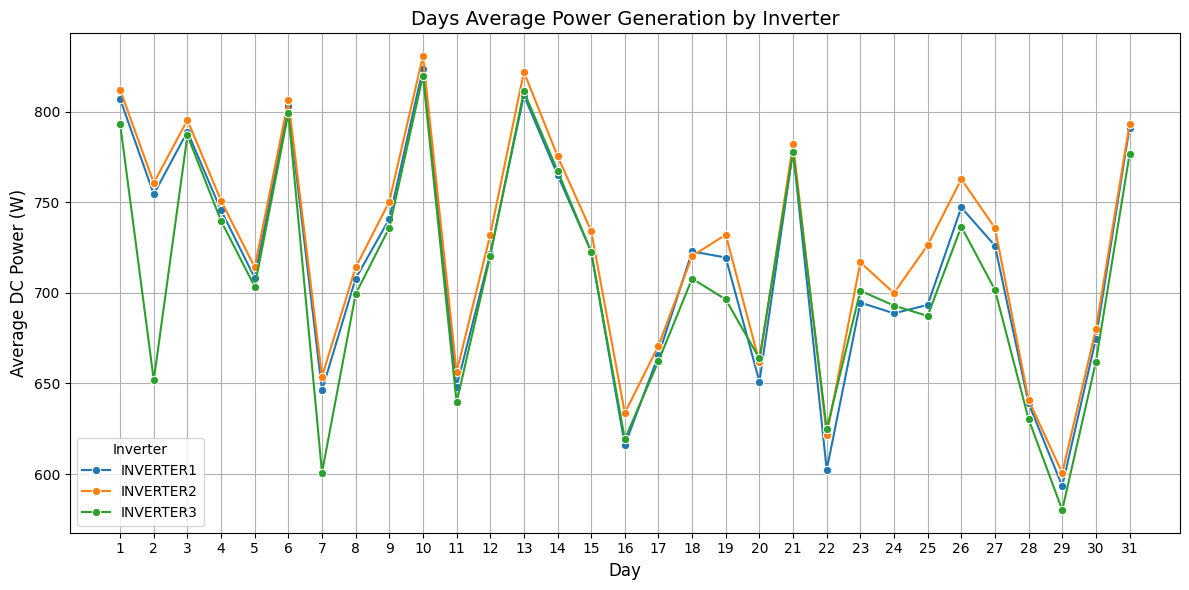

In [17]:
# Group by 'Day' and 'Inverter', then calculate the mean of 'DC POWER' for each group
Day_avg_power = data.groupby(['Day', 'Inverter'])['DC POWER'].mean().reset_index()

# Plot the Days average power for each inverter
plt.figure(figsize=(12, 6))
sns.lineplot(x='Day', y='DC POWER', hue='Inverter', data=Day_avg_power, marker='o')

# Adding labels and title
plt.title('Days Average Power Generation by Inverter', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Average DC Power (W)', fontsize=12)
plt.xticks(ticks=range(1, 32), labels=range(1, 32))  # Ensure the x-axis has 31 days
plt.grid(True)
plt.legend(title='Inverter', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20820\787619136.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Month_avg_power = data.groupby(['Month', 'Inverter'])['DC POWER'].mean().reset_index()


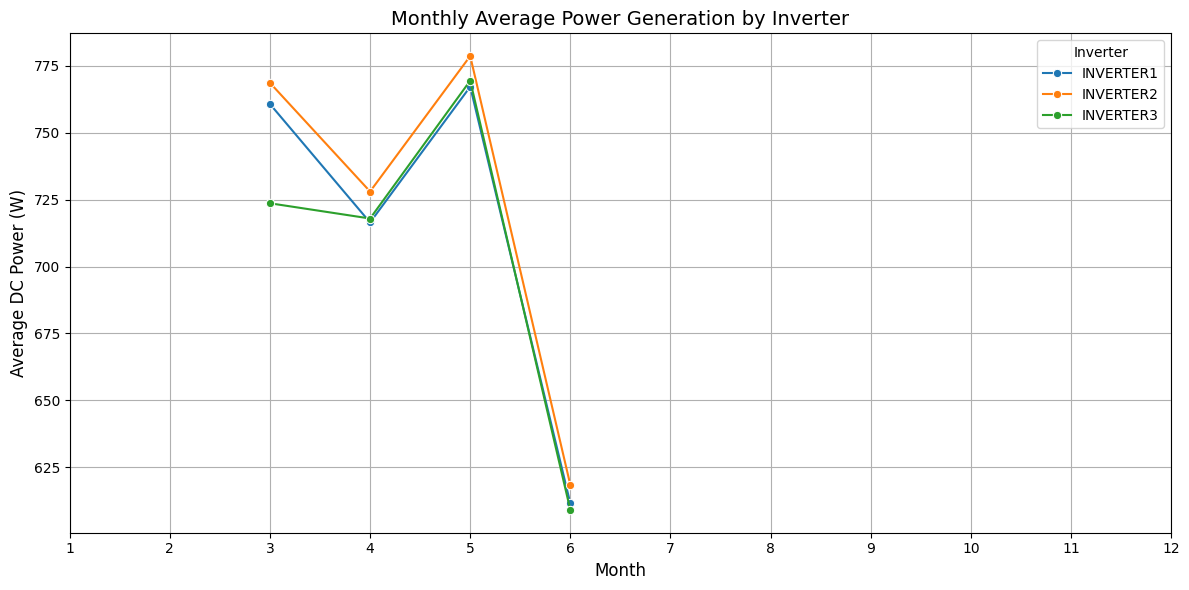

In [18]:
# Group by 'Month' and 'Inverter', then calculate the mean of 'DC POWER' for each group
Month_avg_power = data.groupby(['Month', 'Inverter'])['DC POWER'].mean().reset_index()

# Plot the months average power for each inverter
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='DC POWER', hue='Inverter', data=Month_avg_power, marker='o')

# Adding labels and title
plt.title('Monthly Average Power Generation by Inverter', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average DC Power (W)', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=range(1, 13))  # Ensure the x-axis has 12 months
plt.grid(True)
plt.legend(title='Inverter', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd

# Define custom bins for the 'Hour' column
bins = [-1, 4, 9, 14, 18]  # Adjust the last bin edge to 24
labels = ['Night', 'Morning', 'Afternoon', 'Evening']  # Remove duplicate 'Night'

# Create a new column 'TimeOfDay' based on the bins
data['TimeOfDay'] = pd.cut(data['Hour'], bins=bins, labels=labels, right=True, include_lowest=True)

# For the hours 19 to 23, set them to 'Night' after binning
data.loc[data['Hour'].between(19, 23), 'TimeOfDay'] = 'Night'

# Display the first few rows of the dataframe to check the new column
print(data[['Hour', 'TimeOfDay']].head(10))

                     Hour TimeOfDay
DATE & TIME                        
2024-03-01 00:00:00     0     Night
2024-03-01 00:00:00     0     Night
2024-03-01 00:00:00     0     Night
2024-03-01 00:01:00     0     Night
2024-03-01 00:01:00     0     Night
2024-03-01 00:01:00     0     Night
2024-03-01 00:02:00     0     Night
2024-03-01 00:02:00     0     Night
2024-03-01 00:02:00     0     Night
2024-03-01 00:03:00     0     Night


In [21]:
data.drop(columns=["Power_Match"], inplace=True)

In [22]:
data['TimeOfDay'].unique()

['Night', 'Morning', 'Afternoon', 'Evening']
Categories (4, object): ['Night' < 'Morning' < 'Afternoon' < 'Evening']

In [23]:
data

,DC VOLTAGE,DC POWER,TEMPERATURE,Inverter,HUMIDITY,AMBIENT TEMPERATURE,Hour,Day,Month,TimeOfDay
DATE & TIME,,,,,,,,,,
2024-03-01 00:00:00,0.000000,0.0,29.799999,INVERTER1,0.0,0.0,0,1,3,Night
2024-03-01 00:00:00,0.000000,0.0,30.600000,INVERTER2,0.0,0.0,0,1,3,Night
2024-03-01 00:00:00,0.000000,0.0,27.500000,INVERTER3,0.0,0.0,0,1,3,Night
2024-03-01 00:01:00,0.000000,0.0,29.799999,INVERTER1,0.0,0.0,0,1,3,Night
2024-03-01 00:01:00,0.000000,0.0,30.600000,INVERTER2,0.0,0.0,0,1,3,Night
...,...,...,...,...,...,...,...,...,...,...
2024-06-30 23:58:00,0.000000,0.0,31.900000,INVERTER2,0.0,0.0,23,30,6,Night
2024-06-30 23:58:00,1099.900024,0.0,27.200001,INVERTER3,0.0,0.0,23,30,6,Night
2024-06-30 23:59:00,0.000000,0.0,31.200001,INVERTER1,0.0,0.0,23,30,6,Night


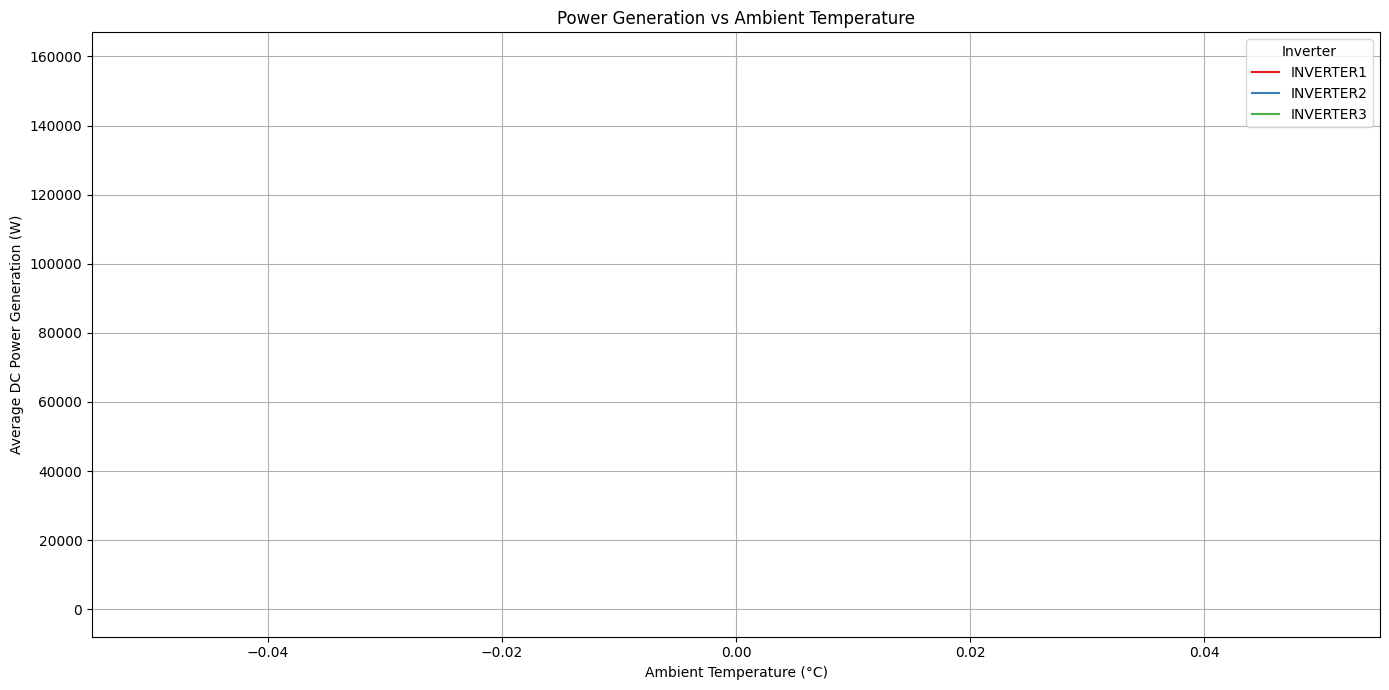

In [24]:
filtered_data = data[data['TimeOfDay'].isin(['Night'])]

# Create a line plot with ambient temperature on the x-axis and DC power on the y-axis
plt.figure(figsize=(14, 7))
sns.lineplot(data=filtered_data, x='AMBIENT TEMPERATURE', y='DC POWER', hue='Inverter', 
             estimator='sum', palette='Set1')

# Set titles and labels
plt.title('Power Generation vs Ambient Temperature')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('Average DC Power Generation (W)')
plt.legend(title='Inverter')
plt.grid()
plt.tight_layout()

# Show plot
plt.show()

In [25]:
data = data[data['TimeOfDay'] != 'Night']

In [37]:
data

,DC VOLTAGE,DC POWER,TEMPERATURE,Inverter,HUMIDITY,AMBIENT TEMPERATURE,Hour,Day,Month,TimeOfDay,Anomaly_IF
DATE & TIME,,,,,,,,,,,
2024-03-01 05:00:00,0.000000,0.0,29.799999,INVERTER1,0.0,0.0,5,1,3,Morning,-1
2024-03-01 05:00:00,0.000000,0.0,30.600000,INVERTER2,0.0,0.0,5,1,3,Morning,-1
2024-03-01 05:00:00,0.000000,0.0,27.500000,INVERTER3,0.0,0.0,5,1,3,Morning,-1
2024-03-01 05:01:00,0.000000,0.0,29.799999,INVERTER1,0.0,0.0,5,1,3,Morning,-1
2024-03-01 05:01:00,0.000000,0.0,30.600000,INVERTER2,0.0,0.0,5,1,3,Morning,-1
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 18:58:00,552.900024,0.0,31.400000,INVERTER2,0.0,0.0,18,30,6,Evening,1
2024-06-30 18:58:00,1100.000000,0.0,28.000000,INVERTER3,0.0,0.0,18,30,6,Evening,1
2024-06-30 18:59:00,0.000000,0.0,30.600000,INVERTER1,0.0,0.0,18,30,6,Evening,-1


In [27]:
# Initialize scaler
scaler = StandardScaler()

data_scaled = data[["DC VOLTAGE", "DC POWER", "TEMPERATURE", "HUMIDITY", "AMBIENT TEMPERATURE"]].copy()

# Fit and transform in place
data_scaled = scaler.fit_transform(data_scaled.astype('float32'))

In [28]:
data_scaled

array([[-7.434892  , -1.230966  , -0.9704652 , -1.7543204 , -2.3826048 ],
       [-7.434892  , -1.230966  , -0.83868587, -1.7543204 , -2.3826048 ],
       [-7.434892  , -1.230966  , -1.3493301 , -1.7543204 , -2.3826048 ],
       ...,
       [-7.434892  , -1.230966  , -0.83868587, -1.7543204 , -2.3826048 ],
       [-3.8441312 , -1.230966  , -0.70690686, -1.7543204 , -2.3826048 ],
       [ 0.15073638, -1.230966  , -1.2669681 , -1.7543204 , -2.3826048 ]],
      dtype=float32)

In [41]:
# Initialize Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,  # Adjust based on expected anomaly rate
    random_state=42,
    n_jobs=-1  # Utilize all available CPU cores
)

# Fit the model
iso_forest.fit(data_scaled)

# Predict anomalies (-1 for anomaly, 1 for normal)
data.loc[:, 'Anomaly_IF'] = iso_forest.fit_predict(data_scaled)

In [76]:
data

,DC VOLTAGE,DC POWER,TEMPERATURE,Inverter,HUMIDITY,AMBIENT TEMPERATURE,Hour,Day,Month,TimeOfDay,Anomaly_IF,Anomaly_SVM,Anomaly_LOF
DATE & TIME,,,,,,,,,,,,,
2024-03-01 05:00:00,0.000000,0.0,29.799999,INVERTER1,0.0,0.0,5,1,3,Morning,-1,1,1
2024-03-01 05:00:00,0.000000,0.0,30.600000,INVERTER2,0.0,0.0,5,1,3,Morning,-1,1,1
2024-03-01 05:00:00,0.000000,0.0,27.500000,INVERTER3,0.0,0.0,5,1,3,Morning,-1,-1,1
2024-03-01 05:01:00,0.000000,0.0,29.799999,INVERTER1,0.0,0.0,5,1,3,Morning,-1,1,1
2024-03-01 05:01:00,0.000000,0.0,30.600000,INVERTER2,0.0,0.0,5,1,3,Morning,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 18:58:00,552.900024,0.0,31.400000,INVERTER2,0.0,0.0,18,30,6,Evening,1,1,1
2024-06-30 18:58:00,1100.000000,0.0,28.000000,INVERTER3,0.0,0.0,18,30,6,Evening,1,1,1
2024-06-30 18:59:00,0.000000,0.0,30.600000,INVERTER1,0.0,0.0,18,30,6,Evening,-1,1,1


In [45]:
# Filter anomalies
anomalies = data[data['Anomaly_IF'] == -1]
print(f"Number of anomalies detected: {len(anomalies)}")

Number of anomalies detected: 3073


In [47]:
anomalies.describe()

,DC VOLTAGE,DC POWER,TEMPERATURE,HUMIDITY,AMBIENT TEMPERATURE,Hour,Day,Month,Anomaly_IF
count,3073.000000,3073.0,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.0
mean,20.977480,0.0,26.814417,23.033876,5.744973,9.233973,14.441588,3.669704,-1.0
std,51.587536,0.0,13.901255,38.350285,9.732901,5.657337,9.421962,0.773871,0.0
min,0.000000,0.0,0.000000,0.000000,0.000000,5.000000,1.000000,3.000000,-1.0
25%,0.000000,0.0,27.500000,0.000000,0.000000,5.000000,6.000000,3.000000,-1.0
50%,0.000000,0.0,30.600000,0.000000,0.000000,6.000000,13.000000,4.000000,-1.0
75%,18.000000,0.0,35.799999,65.199997,17.200001,18.000000,23.000000,4.000000,-1.0
max,326.899994,0.0,44.799999,99.900002,42.400002,18.000000,31.000000,6.000000,-1.0


In [48]:
anomalies.to_excel('anomalies.xlsx', index=True)

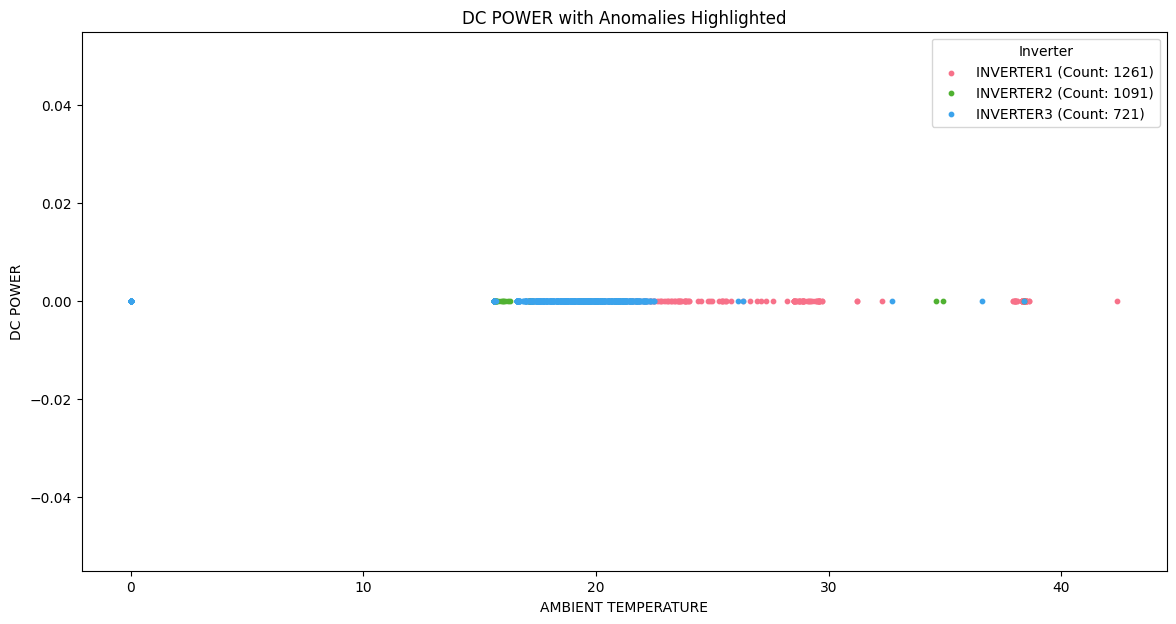

In [117]:
# Create a scatter plot for anomalies, color-coded by inverter type
plt.figure(figsize=(14, 7))

# Using seaborn to create a palette for the inverter types
palette = sns.color_palette("husl", len(anomalies['Inverter'].unique()))

# Create a scatter plot for each inverter
for i, inverter in enumerate(anomalies['Inverter'].unique()):
    inverter_data = anomalies[anomalies['Inverter'] == inverter]
    plt.scatter(inverter_data['AMBIENT TEMPERATURE'], inverter_data['DC POWER'], 
                color=palette[i], label=f'{inverter} (Count: {len(inverter_data)})', s=10)

plt.legend(title='Inverter')
plt.title('DC POWER with Anomalies Highlighted')
plt.xlabel('AMBIENT TEMPERATURE')
plt.ylabel('DC POWER')
plt.show()


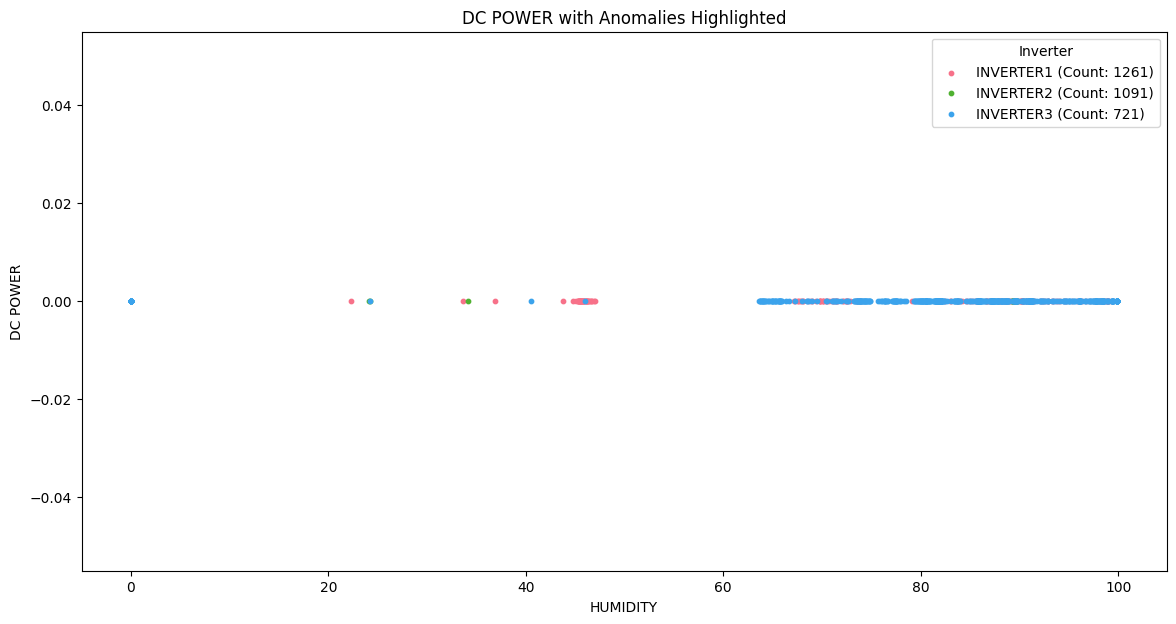

In [116]:
# Create a scatter plot for anomalies, color-coded by inverter type
plt.figure(figsize=(14, 7))

# Using seaborn to create a palette for the inverter types
palette = sns.color_palette("husl", len(anomalies['Inverter'].unique()))

# Create a scatter plot for each inverter
for i, inverter in enumerate(anomalies['Inverter'].unique()):
    inverter_data = anomalies[anomalies['Inverter'] == inverter]
    plt.scatter(inverter_data['HUMIDITY'], inverter_data['DC POWER'], 
                color=palette[i], label=f'{inverter} (Count: {len(inverter_data)})', s=10)

plt.legend(title='Inverter')
plt.title('DC POWER with Anomalies Highlighted')
plt.xlabel('HUMIDITY')
plt.ylabel('DC POWER')
plt.show()


In [49]:
# Initialize One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)  # Adjust 'nu' for anomaly rate

# Initialize Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)

In [65]:
data.loc[:, 'Anomaly_SVM'] = oc_svm.fit_predict(data_scaled)

In [66]:
data

,DC VOLTAGE,DC POWER,TEMPERATURE,Inverter,HUMIDITY,AMBIENT TEMPERATURE,Hour,Day,Month,TimeOfDay,Anomaly_IF,Anomaly_SVM,Anomaly_LOF
DATE & TIME,,,,,,,,,,,,,
2024-03-01 05:00:00,0.000000,0.0,29.799999,INVERTER1,0.0,0.0,5,1,3,Morning,-1,1,1
2024-03-01 05:00:00,0.000000,0.0,30.600000,INVERTER2,0.0,0.0,5,1,3,Morning,-1,1,1
2024-03-01 05:00:00,0.000000,0.0,27.500000,INVERTER3,0.0,0.0,5,1,3,Morning,-1,-1,1
2024-03-01 05:01:00,0.000000,0.0,29.799999,INVERTER1,0.0,0.0,5,1,3,Morning,-1,1,1
2024-03-01 05:01:00,0.000000,0.0,30.600000,INVERTER2,0.0,0.0,5,1,3,Morning,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 18:58:00,552.900024,0.0,31.400000,INVERTER2,0.0,0.0,18,30,6,Evening,1,1,1
2024-06-30 18:58:00,1100.000000,0.0,28.000000,INVERTER3,0.0,0.0,18,30,6,Evening,1,1,1
2024-06-30 18:59:00,0.000000,0.0,30.600000,INVERTER1,0.0,0.0,18,30,6,Evening,-1,1,1


In [54]:
# Filter anomalies for each model
anomalies_iso = data[data['Anomaly_IF'] == -1]
anomalies_svm = data[data['Anomaly_SVM'] == -1]

In [64]:
anomalies_svm

,DC VOLTAGE,DC POWER,TEMPERATURE,Inverter,HUMIDITY,AMBIENT TEMPERATURE,Hour,Day,Month,TimeOfDay,Anomaly_IF,Anomaly_SVM
DATE & TIME,,,,,,,,,,,,
2024-03-01 05:00:00,0.0,0.0,27.500000,INVERTER3,0.000000,0.000000,5,1,3,Morning,-1,-1
2024-03-01 05:01:00,0.0,0.0,27.500000,INVERTER3,0.000000,0.000000,5,1,3,Morning,-1,-1
2024-03-01 05:02:00,0.0,0.0,27.500000,INVERTER3,0.000000,0.000000,5,1,3,Morning,-1,-1
2024-03-01 05:03:00,0.0,0.0,27.500000,INVERTER3,0.000000,0.000000,5,1,3,Morning,-1,-1
2024-03-01 05:04:00,0.0,0.0,27.500000,INVERTER3,0.000000,0.000000,5,1,3,Morning,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 18:06:00,0.0,0.0,29.799999,INVERTER1,90.199997,25.500000,18,30,6,Evening,-1,-1
2024-06-30 18:07:00,0.0,0.0,29.900000,INVERTER1,90.099998,25.400000,18,30,6,Evening,-1,-1
2024-06-30 18:08:00,0.0,0.0,30.000000,INVERTER1,89.699997,25.400000,18,30,6,Evening,-1,-1


In [86]:
anomalies['Inverter'].unique()

['INVERTER1', 'INVERTER2', 'INVERTER3']
Categories (3, object): ['INVERTER1', 'INVERTER2', 'INVERTER3']

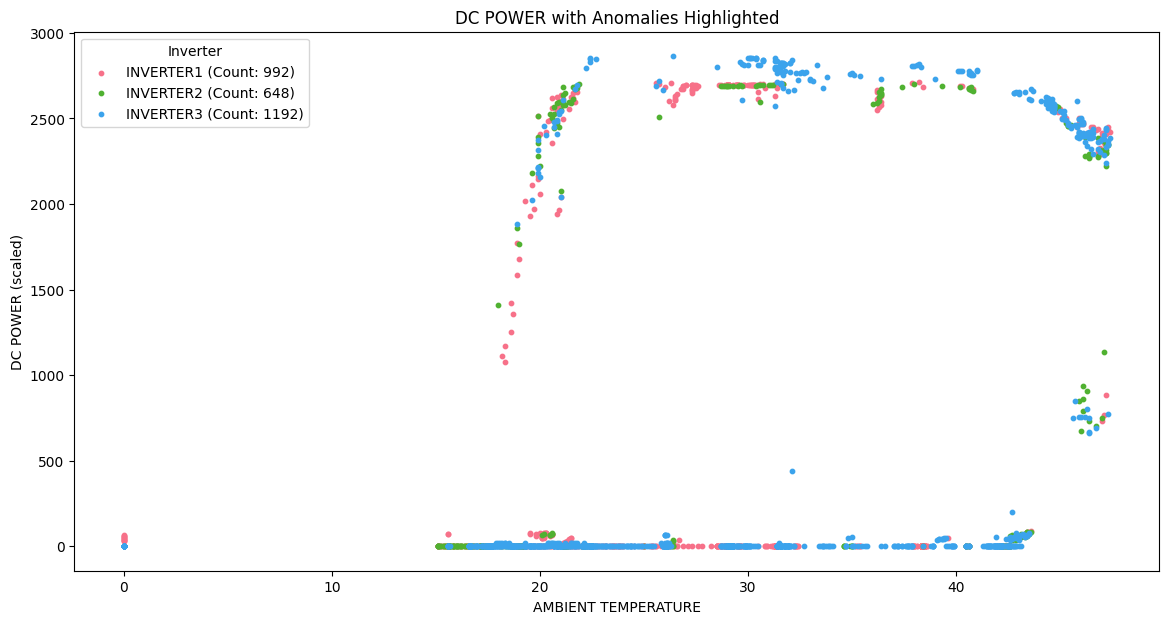

In [104]:
# Create a scatter plot for anomalies, color-coded by inverter type
plt.figure(figsize=(14, 7))

# Using seaborn to create a color palette for the inverter types
palette = sns.color_palette("husl", len(anomalies_svm['Inverter'].unique()))

# Create a scatter plot for each inverter
for i, inverter in enumerate(anomalies['Inverter'].unique()):
    inverter_data = anomalies_svm[anomalies_svm['Inverter'] == inverter]
    plt.scatter(inverter_data['AMBIENT TEMPERATURE'], inverter_data['DC POWER'], 
                color=palette[i], label=f'{inverter} (Count: {len(inverter_data)})', s=10)

plt.legend(title='Inverter')
plt.title('DC POWER with Anomalies Highlighted')
plt.xlabel('AMBIENT TEMPERATURE')
plt.ylabel('DC POWER (scaled)')
plt.show()


In [57]:
lof.fit(data_scaled)

LocalOutlierFactor(contamination=0.01, novelty=True)

In [60]:
data.loc[:, 'Anomaly_LOF'] = lof.predict(data_scaled)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20820\2360280967.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Anomaly_LOF'] = lof.predict(data_scaled)


In [69]:
anomalies_lof = data[data['Anomaly_LOF'] == -1]

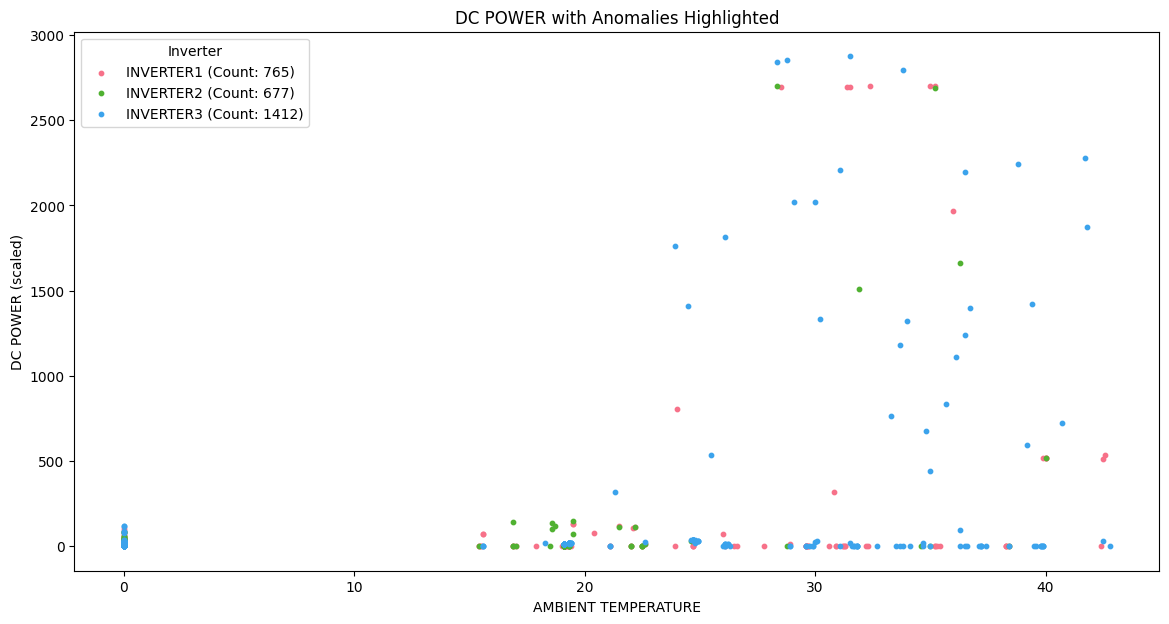

In [106]:
# Create a scatter plot for anomalies, color-coded by inverter type
plt.figure(figsize=(14, 7))

# Using seaborn to create a palette for the inverter types
palette = sns.color_palette("husl", len(anomalies_lof['Inverter'].unique()))

# Create a scatter plot for each inverter
for i, inverter in enumerate(anomalies['Inverter'].unique()):
    inverter_data = anomalies_lof[anomalies_lof['Inverter'] == inverter]
    plt.scatter(inverter_data['AMBIENT TEMPERATURE'], inverter_data['DC POWER'], 
                color=palette[i], label=f'{inverter} (Count: {len(inverter_data)})', s=10)

plt.legend(title='Inverter')
plt.title('DC POWER with Anomalies Highlighted')
plt.xlabel('AMBIENT TEMPERATURE')
plt.ylabel('DC POWER (scaled)')
plt.show()


In [71]:
# Define evaluation metric functions (since there's no ground truth, we will compare based on output similarity)
def evaluation_metrics(model_name, anomaly_labels):
    tn, fp, fn, tp = confusion_matrix(data['Anomaly_IF'], anomaly_labels, labels=[1, -1]).ravel()
    accuracy = accuracy_score(data['Anomaly_IF'], anomaly_labels)
    precision = precision_score(data['Anomaly_IF'], anomaly_labels, pos_label=-1)
    recall = recall_score(data['Anomaly_IF'], anomaly_labels, pos_label=-1)
    f1 = f1_score(data['Anomaly_IF'], anomaly_labels, pos_label=-1)
    
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Confusion Matrix: \n{tn, fp, fn, tp}")
    print("="*50)


In [72]:
# Evaluate each model compared to Isolation Forest results
evaluation_metrics("One-Class SVM", data['Anomaly_SVM'])
evaluation_metrics("Local Outlier Factor (LOF)", data['Anomaly_LOF'])

One-Class SVM Metrics:
Accuracy: 0.9861
Precision: 0.2888
Recall: 0.2662
F1-Score: 0.2771
Confusion Matrix: 
(302233, 2014, 2255, 818)
Local Outlier Factor (LOF) Metrics:
Accuracy: 0.9815
Precision: 0.0403
Recall: 0.0374
F1-Score: 0.0388
Confusion Matrix: 
(301508, 2739, 2958, 115)


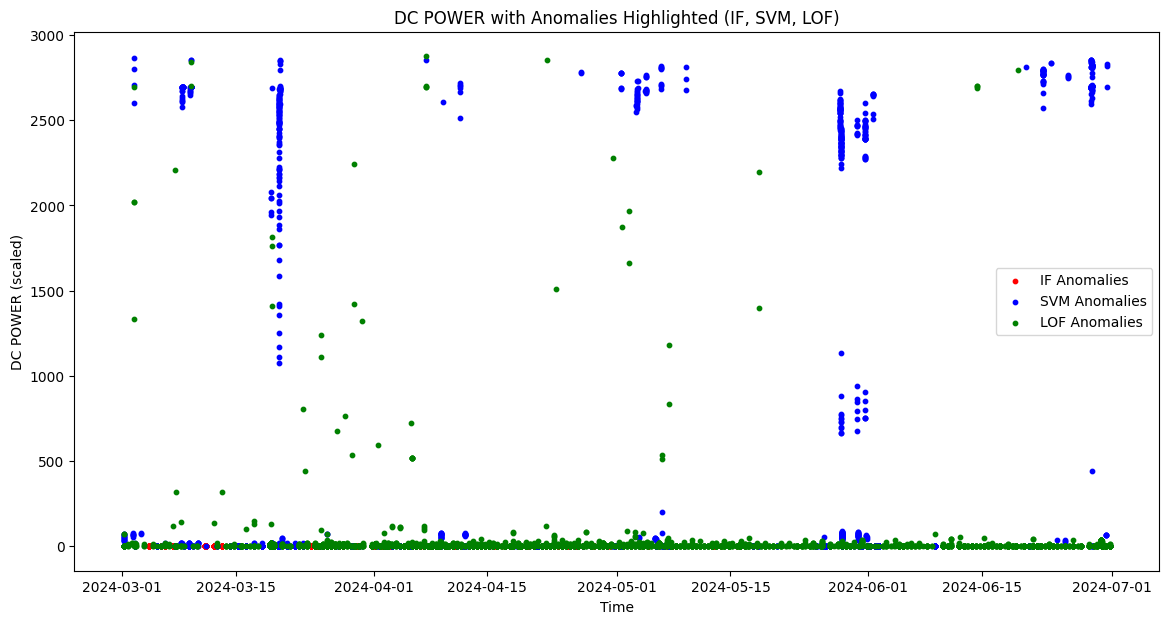

In [96]:
# Visualization of Anomalies
plt.figure(figsize=(14,7))

# Plot for Isolation Forest
plt.scatter(anomalies.index, anomalies['DC POWER'], color='red', label='IF Anomalies', s=10)

# Plot for SVM
plt.scatter(anomalies_svm.index, anomalies_svm['DC POWER'], color='blue', label='SVM Anomalies', s=10)

# Plot for LOF
plt.scatter(anomalies_lof.index, anomalies_lof['DC POWER'], color='green', label='LOF Anomalies', s=10)

plt.legend()
plt.title('DC POWER with Anomalies Highlighted (IF, SVM, LOF)')
plt.xlabel('Time')
plt.ylabel('DC POWER (scaled)')
plt.show()


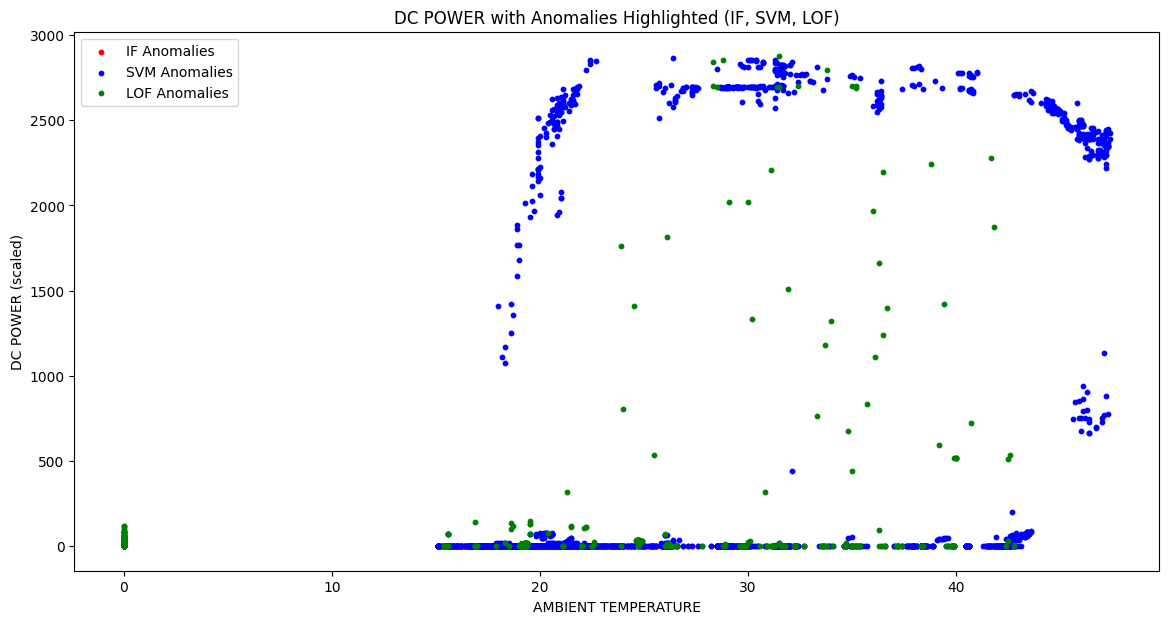

In [108]:
# Visualization of Anomalies
plt.figure(figsize=(14,7))

# Plot for Isolation Forest
plt.scatter(anomalies['AMBIENT TEMPERATURE'], anomalies['DC POWER'], color='red', label='IF Anomalies', s=10)

# Plot for SVM
plt.scatter(anomalies_svm['AMBIENT TEMPERATURE'], anomalies_svm['DC POWER'], color='blue', label='SVM Anomalies', s=10)

# Plot for LOF
plt.scatter(anomalies_lof['AMBIENT TEMPERATURE'], anomalies_lof['DC POWER'], color='green', label='LOF Anomalies', s=10)

plt.legend()
plt.title('DC POWER with Anomalies Highlighted (IF, SVM, LOF)')
plt.xlabel('AMBIENT TEMPERATURE')
plt.ylabel('DC POWER (scaled)')
plt.show()


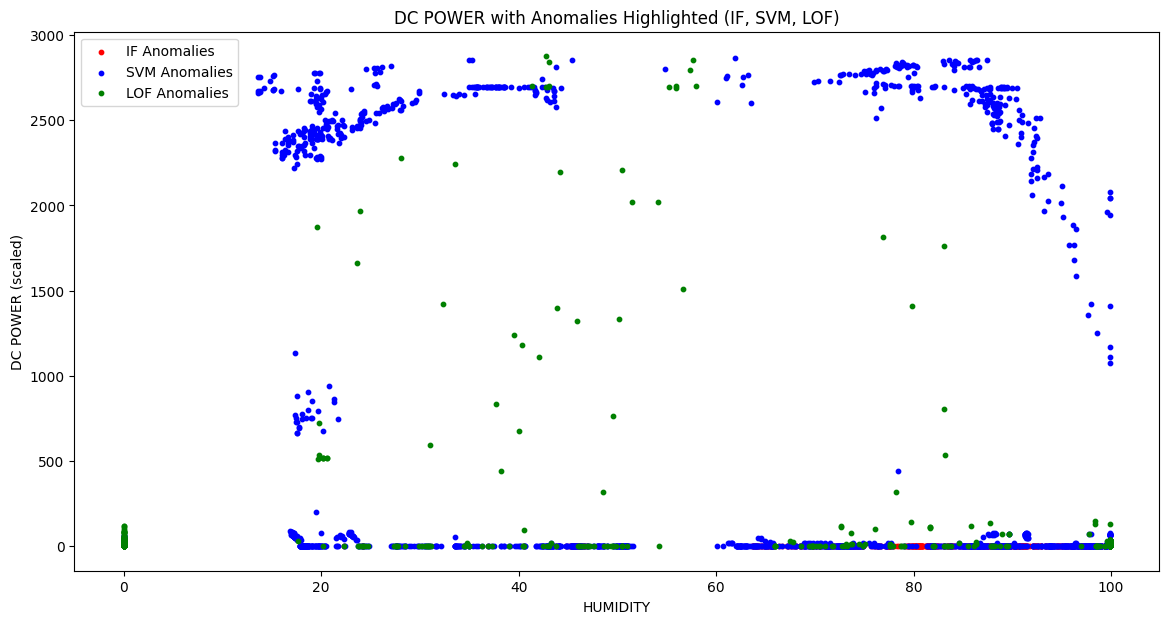

In [99]:
# Visualization of Anomalies
plt.figure(figsize=(14,7))

# Plot for Isolation Forest
plt.scatter(anomalies.HUMIDITY, anomalies['DC POWER'], color='red', label='IF Anomalies', s=10)

# Plot for SVM
plt.scatter(anomalies_svm.HUMIDITY, anomalies_svm['DC POWER'], color='blue', label='SVM Anomalies', s=10)

# Plot for LOF
plt.scatter(anomalies_lof.HUMIDITY, anomalies_lof['DC POWER'], color='green', label='LOF Anomalies', s=10)

plt.legend()
plt.title('DC POWER with Anomalies Highlighted (IF, SVM, LOF)')
plt.xlabel('HUMIDITY')
plt.ylabel('DC POWER (scaled)')
plt.show()


In [ ]:
#data.to_csv('data.csv', index=True) 

In [67]:
#data.to_excel('data.xlsx', index=True)

In [114]:
#FROM HERE IT'S ROUGH ANALYSIS

In [109]:
data

,DC VOLTAGE,DC POWER,TEMPERATURE,Inverter,HUMIDITY,AMBIENT TEMPERATURE,Hour,Day,Month,TimeOfDay,Anomaly_IF,Anomaly_SVM,Anomaly_LOF
DATE & TIME,,,,,,,,,,,,,
2024-03-01 05:00:00,0.000000,0.0,29.799999,INVERTER1,0.0,0.0,5,1,3,Morning,-1,1,1
2024-03-01 05:00:00,0.000000,0.0,30.600000,INVERTER2,0.0,0.0,5,1,3,Morning,-1,1,1
2024-03-01 05:00:00,0.000000,0.0,27.500000,INVERTER3,0.0,0.0,5,1,3,Morning,-1,-1,1
2024-03-01 05:01:00,0.000000,0.0,29.799999,INVERTER1,0.0,0.0,5,1,3,Morning,-1,1,1
2024-03-01 05:01:00,0.000000,0.0,30.600000,INVERTER2,0.0,0.0,5,1,3,Morning,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 18:58:00,552.900024,0.0,31.400000,INVERTER2,0.0,0.0,18,30,6,Evening,1,1,1
2024-06-30 18:58:00,1100.000000,0.0,28.000000,INVERTER3,0.0,0.0,18,30,6,Evening,1,1,1
2024-06-30 18:59:00,0.000000,0.0,30.600000,INVERTER1,0.0,0.0,18,30,6,Evening,-1,1,1


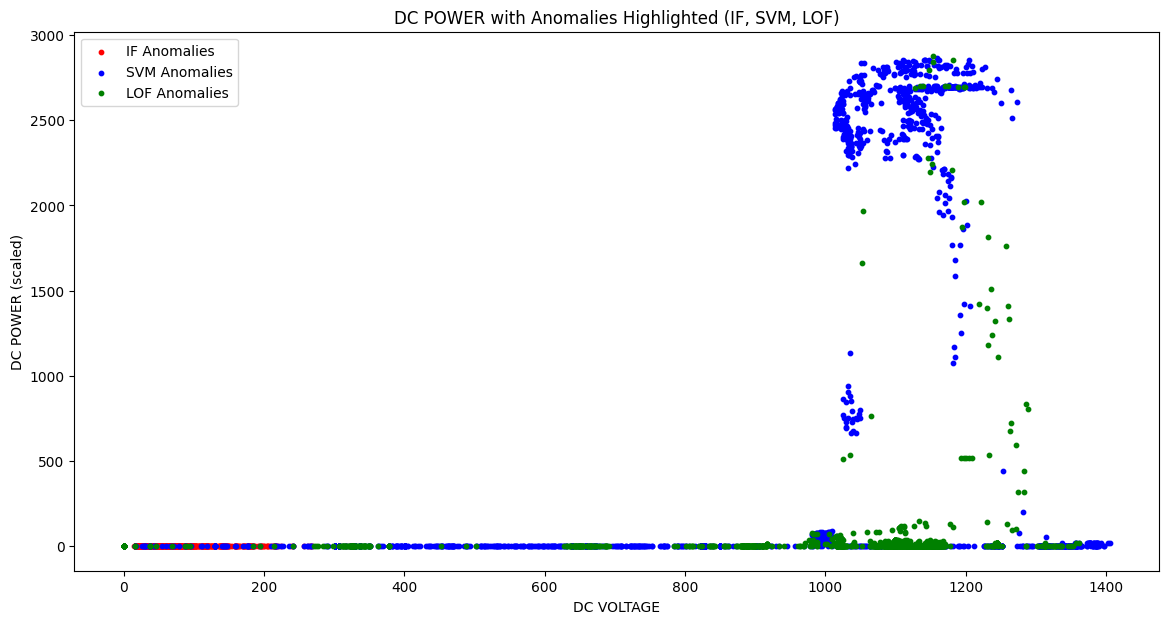

In [110]:
# Visualization of Anomalies
plt.figure(figsize=(14,7))

# Plot for Isolation Forest
plt.scatter(anomalies['DC VOLTAGE'], anomalies['DC POWER'], color='red', label='IF Anomalies', s=10)

# Plot for SVM
plt.scatter(anomalies_svm['DC VOLTAGE'], anomalies_svm['DC POWER'], color='blue', label='SVM Anomalies', s=10)

# Plot for LOF
plt.scatter(anomalies_lof['DC VOLTAGE'], anomalies_lof['DC POWER'], color='green', label='LOF Anomalies', s=10)

plt.legend()
plt.title('DC POWER with Anomalies Highlighted (IF, SVM, LOF)')
plt.xlabel('DC VOLTAGE')
plt.ylabel('DC POWER (scaled)')
plt.show()


In [111]:
data.describe()

,DC VOLTAGE,DC POWER,TEMPERATURE,HUMIDITY,AMBIENT TEMPERATURE,Hour,Day,Month,Anomaly_IF,Anomaly_SVM,Anomaly_LOF
count,307320.000000,307320.000000,307320.000000,307320.000000,307320.000000,307320.000000,307320.000000,307320.000000,307320.000000,307320.000000,307320.000000
mean,1078.141479,1225.296143,35.691467,45.260838,29.178482,11.501669,15.752528,4.492376,0.980001,0.981570,0.981427
std,145.011292,995.395569,6.070774,25.799686,12.246484,4.030941,8.808148,1.117844,0.198991,0.191105,0.191839
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,3.000000,-1.000000,-1.000000,-1.000000
25%,1071.000000,232.600006,31.200001,30.100000,26.799999,8.000000,8.000000,3.000000,1.000000,1.000000,1.000000
50%,1100.000000,1080.300049,35.500000,44.500000,32.200001,12.000000,16.000000,5.000000,1.000000,1.000000,1.000000
75%,1125.300049,2239.699951,40.299999,62.799999,37.400002,15.000000,23.000000,5.000000,1.000000,1.000000,1.000000
max,1406.099976,2875.500000,51.400002,99.900002,47.599998,18.000000,31.000000,6.000000,1.000000,1.000000,1.000000
